In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

from collections import Counter


KMER = 6
DIR_EXP = Path(f"../experiments-paper/{KMER}mer")
NAME_EXPERIMENT = "07_25_2024-autoencoder"

path_experiment = DIR_EXP.joinpath(NAME_EXPERIMENT)


labels issues and outliers are saved in the order of the test sets used for kfold cross-validation
___
Get labels from kfold cross-validation

In [2]:
kfold_test = list(
    path_experiment.joinpath("cross-validation").glob("test*")
)
kfold_test.sort()

paths_fcgr = []
labels = []

for kfold in kfold_test:

    with open(kfold) as fp:
        for line in fp.readlines():
            path_fcgr, label = line.strip().split("\t")

            # if path_fcgr not in df_outliers.path:
            labels.append(label)
            paths_fcgr.append(path_fcgr)

df_labels = pd.DataFrame({
    "path_fcgr": paths_fcgr,
    "label": labels
})
df_labels["sample_id"] = df_labels.path_fcgr.apply(lambda s: Path(s).stem)
df_labels["tarfile"] = df_labels.path_fcgr.apply(lambda s: Path(s).parent.stem)
df_labels.head()

,path_fcgr,label,sample_id,tarfile
0,data/fcgr/6mer/salmonella_enterica__20/SAMN060...,salmonella_enterica,SAMN06034028,salmonella_enterica__20
1,data/fcgr/6mer/escherichia_coli__21/SAMN097384...,escherichia_coli,SAMN09738459,escherichia_coli__21
2,data/fcgr/6mer/salmonella_enterica__46/SAMN103...,salmonella_enterica,SAMN10391382,salmonella_enterica__46
3,data/fcgr/6mer/neisseria_meningitidis__02/SAME...,neisseria_meningitidis,SAMEA2147963,neisseria_meningitidis__02
4,data/fcgr/6mer/salmonella_enterica__18/SAMN053...,salmonella_enterica,SAMN05357778,salmonella_enterica__18


get mapping integer label -> species label

In [3]:
unique_labels = list(df_labels.label.unique())
unique_labels.sort()
dict_int2label = {idx: label for idx, label in enumerate(unique_labels)}

### Label issues
___

In [4]:
# label issues
path_cf = path_experiment.joinpath("cross-validation/confident-learning")
int_labels = np.load( path_cf.joinpath("labels.npy") )  # integer labels
labels = [dict_int2label[int(x)] for x in int_labels]   # species name labels
len(labels)

657775

In [5]:
pred_probs = np.load( path_cf.joinpath("pred_probs.npy") )
preds = [dict_int2label[int(x)] for x in pred_probs.argmax(axis=1) ]
df_labels["pred"] = preds
len(preds)

657775

In [6]:
label_issues = np.load( path_cf.joinpath("label_issues.npy") ) 
df_labels_issues = df_labels.loc[label_issues].copy()
df_labels_issues

,path_fcgr,label,sample_id,tarfile,pred
25,data/fcgr/6mer/staphylococcus_aureus__10/SAMN0...,staphylococcus_aureus,SAMN02391400,staphylococcus_aureus__10,enterococcus_faecium
41,data/fcgr/6mer/dustbin__04/SAMN05734408.npy,providencia_sp._wchpr000369,SAMN05734408,dustbin__04,providencia_alcalifaciens
46,data/fcgr/6mer/dustbin__16/SAMEA1462955.npy,bacteroides_ovatus,SAMEA1462955,dustbin__16,megasphaera_hexanoica
108,data/fcgr/6mer/dustbin__19/SAMN04477626.npy,enterococcus_cecorum,SAMN04477626,dustbin__19,staphylococcus_epidermidis
112,data/fcgr/6mer/dustbin__17/SAMN04487944.npy,xanthomonas_euvesicatoria,SAMN04487944,dustbin__17,lactobacillus_gasseri
...,...,...,...,...,...
657082,data/fcgr/6mer/dustbin__18/SAMN05216290.npy,pseudopedobacter_saltans,SAMN05216290,dustbin__18,haliscomenobacter_hydrossis
657106,data/fcgr/6mer/dustbin__19/SAMN00998671.npy,corynebacterium_glutamicum,SAMN00998671,dustbin__19,corynebacterium_striatum
657183,data/fcgr/6mer/mycolicibacterium_smegmatis__01...,mycolicibacterium_smegmatis,SAMN08961557,mycolicibacterium_smegmatis__01,mycolicibacterium_gilvum
657209,data/fcgr/6mer/dustbin__01/SAMN05444320.npy,amycolatopsis_albispora,SAMN05444320,dustbin__01,geodermatophilus_obscurus


Compare against most abundant species
___

In [16]:
df_most_abundant = pd.read_csv("../data/three_most_abundant-krakenbracken.txt",sep="\t")
df_most_abundant.rename({
    "V2": "species1",
    "V3": "abundancy1",
    "V4": "species2",
    "V5": "abundancy2",
    "V6": "species3",
    "V7": "abundancy3",
}, inplace=True, axis=1)

for feat in ["species1","species2","species3"]:
    df_most_abundant[feat] = df_most_abundant[feat].apply(lambda x: str(x).lower().strip().replace(" ","_"))

In [17]:
df_most_abundant.head()

,sample_id,species1,abundancy1,species2,abundancy2,species3,abundancy3
0,SAMD00000344,lactobacillus_hokkaidonensis,99.093,lactobacillus_plantarum,0.159,lactobacillus_amylophilus,0.110
1,SAMD00000345,xanthomonas_euvesicatoria,27.153,lactobacillus_plantarum,18.485,lactobacillus_brevis,3.043
2,SAMD00000355,streptococcus_pyogenes,97.942,streptococcus_agalactiae,0.883,streptococcus_dysgalactiae,0.858
3,SAMD00000550,corynebacterium_glutamicum,93.780,[brevibacterium]_flavum,2.292,corynebacterium_crudilactis,1.066
4,SAMD00000552,corynebacterium_glutamicum,99.951,kluyveromyces_marxianus,0.015,acetobacter_pasteurianus,0.012


In [19]:
issues = pd.merge(left=df_labels_issues, right=df_most_abundant ,how="left", on="sample_id")

In [27]:
issues.head()

,path_fcgr,label,sample_id,tarfile,pred,species1,abundancy1,species2,abundancy2,species3,abundancy3
0,data/fcgr/6mer/staphylococcus_aureus__10/SAMN0...,staphylococcus_aureus,SAMN02391400,staphylococcus_aureus__10,enterococcus_faecium,staphylococcus_aureus,77.434,enterococcus_casseliflavus,6.579,enterococcus_faecium,6.499
1,data/fcgr/6mer/dustbin__04/SAMN05734408.npy,providencia_sp._wchpr000369,SAMN05734408,dustbin__04,providencia_alcalifaciens,providencia_sp._wchpr000369,45.632,providencia_rettgeri,44.142,providencia_stuartii,3.037
2,data/fcgr/6mer/dustbin__16/SAMEA1462955.npy,bacteroides_ovatus,SAMEA1462955,dustbin__16,megasphaera_hexanoica,bacteroides_ovatus,19.185,bacteroides_thetaiotaomicron,5.579,bacteroides_caecimuris,4.906
3,data/fcgr/6mer/dustbin__19/SAMN04477626.npy,enterococcus_cecorum,SAMN04477626,dustbin__19,staphylococcus_epidermidis,enterococcus_cecorum,2.564,enterococcus_faecium,2.338,jeotgalibaca_sp._pts2502,2.259
4,data/fcgr/6mer/dustbin__17/SAMN04487944.npy,xanthomonas_euvesicatoria,SAMN04487944,dustbin__17,lactobacillus_gasseri,xanthomonas_euvesicatoria,4.763,parageobacillus_thermoglucosidasius,4.194,paraliobacillus_sp._x-1125,3.391


In [35]:
df_references = pd.read_csv("../data/reference_sequences.txt", sep="\t")
df_references.head()

# create dictionary to map label to the reference path
BASEPATH_REF = Path("data/reference_sequences")
label2refpath = {}
for d in df_references.to_dict("records"):
    label = d["label"]
    sample_id = d["sample_id"]
    tarfile = d["tarfile"]

    path_ref = BASEPATH_REF.joinpath(f"{tarfile}/{sample_id}.fa")

    label2refpath[label] = str(path_ref)

label2refpath["absent"] = str(BASEPATH_REF.joinpath("absent.fa"))

In [36]:
label2refpath

{'[clostridium]_bolteae': 'data/reference_sequences/dustbin__02/SAMN05216568.fa',
 '[clostridium]_saccharolyticum': 'data/reference_sequences/dustbin__01/SAMN02440585.fa',
 '[clostridium]_sphenoides': 'data/reference_sequences/dustbin__03/SAMN06342376.fa',
 '[clostridium]_ultunense': 'data/reference_sequences/dustbin__12/SAMN02745784.fa',
 '[enterobacter]_lignolyticus': 'data/reference_sequences/dustbin__21/SAMN00776233.fa',
 '[eubacterium]_eligens': 'data/reference_sequences/dustbin__15/SAMEA3545350.fa',
 '[eubacterium]_hallii': 'data/reference_sequences/eubacterium_hallii__01/SAMEA3545420.fa',
 '[eubacterium]_rectale': 'data/reference_sequences/dustbin__20/SAMEA3545348.fa',
 '[eubacterium]_sulci': 'data/reference_sequences/dustbin__10/SAMEA44043418.fa',
 '[haemophilus]_ducreyi': 'data/reference_sequences/dustbin__19/SAMN09808969.fa',
 '[mannheimia]_succiniciproducens': 'data/reference_sequences/dustbin__21/SAMN02910354.fa',
 'acetoanaerobium_sticklandii': 'data/reference_sequences/du

For each sequence with label issue, create a txt file with 4 rows:
- path to reference of the prediction
- path to reference of the most abundant species (ground truth label)
- path to reference of the second most abundant species
- path to reference of the third most abundant species

In [39]:
path_save = path_experiment.joinpath("cross-validation/confident-learning/lists-ANI")
path_save.mkdir(exist_ok=True, parents=True)

for d in issues.to_dict("records"):
    
    with open(path_save.joinpath(f"{d['sample_id']}.txt"), "w") as fp:
        for l in ["pred","species1","species2","species3"]:
            fp.write(label2refpath.get(d[l],label2refpath["absent"]))
            fp.write("\n")


Collect path to fasta files to extract from each tarfile

In [44]:
from collections import defaultdict
fastas_by_tarfile = defaultdict(list)
for tarfile, sample_id in zip(issues.tarfile, issues.sample_id):
    fastas_by_tarfile[tarfile].append(
                                    f"{tarfile}/{sample_id}.fa"
                                    )

len(fastas_by_tarfile)

273

In [46]:
path_save = path_experiment.joinpath("cross-validation/confident-learning/lists-by-tar")
path_save.mkdir(exist_ok=True, parents=True)

for tarfile, list_files in fastas_by_tarfile.items():
    
    with open(path_save.joinpath(f"{tarfile}.txt"), "w") as fp:
        
        for l in list_files:
            fp.write(l)
            fp.write("\n")

___

In [30]:
# total
num_label_by_specie = Counter(df_labels.label)

# with label issues
counts = Counter(df_labels_issues.label)
counts_label_issues = pd.DataFrame({"species": counts.keys(), "count": counts.values()})

# add total for species
counts_label_issues["total"] = counts_label_issues["species"].apply(lambda s: num_label_by_specie[s])
counts_label_issues["p_issues"] = counts_label_issues.apply(lambda row: row["count"]/row["total"],axis=1)


<Axes: xlabel='count', ylabel='species'>

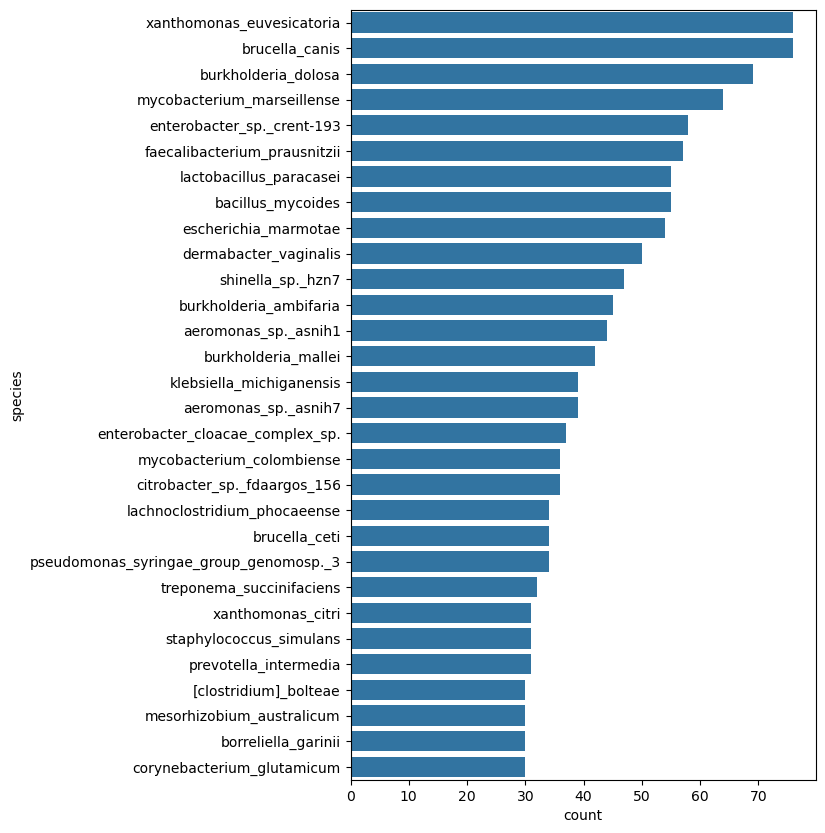

In [31]:
fix, ax = plt.subplots(figsize=(6,10))


feat = "count"
counts_label_issues.sort_values(by=feat, ascending=False, inplace=True)
counts_label_issues.reset_index(inplace=True, drop=True)

sns.barplot(
    data=counts_label_issues.query("total < 100").head(30),
    y="species", x=feat,
    orient="h",
    ax=ax
)

In [32]:
counts_label_issues.query("total < 100").head(20) 

,species,count,total,p_issues
25,xanthomonas_euvesicatoria,76,82,0.926829
27,brucella_canis,76,77,0.987013
34,burkholderia_dolosa,69,71,0.971831
35,mycobacterium_marseillense,64,71,0.901408
42,enterobacter_sp._crent-193,58,59,0.983051
43,faecalibacterium_prausnitzii,57,84,0.678571
45,lactobacillus_paracasei,55,74,0.743243
46,bacillus_mycoides,55,59,0.932203
47,escherichia_marmotae,54,96,0.562500
49,dermabacter_vaginalis,50,65,0.769231


In [33]:
df_label_by_species = pd.DataFrame({
    "species": num_label_by_specie.keys(),
    "count": num_label_by_specie.values(),
})

In [34]:
df_label_by_species.query("count>=100")["count"].sum()

np.int64(636368)

In [35]:
df_label_by_species.query("count<100")["count"].sum()

np.int64(22060)

### Outliers
___

In [ ]:
# outliers
df_outliers = pd.read_csv( path_experiment.joinpath("cross-validation/outliers/outliers.csv"), sep="\t") 

In [ ]:
df_outliers.head()

,Unnamed: 0,path,label,avg_dist
0,3096,data/fcgr/7mer/dustbin__11/SAMN02198976.npy,desulfovibrio_sp._g11,0.787206
1,108651,data/fcgr/7mer/dustbin__07/SAMN01779544.npy,staphylococcus_simulans,0.707801
2,37555,data/fcgr/7mer/salmonella_enterica__14/SAMN037...,salmonella_enterica,0.706409
3,37677,data/fcgr/7mer/dustbin__11/SAMN02745672.npy,haliscomenobacter_hydrossis,0.688854
4,4050,data/fcgr/7mer/escherichia_coli__08/SAMN021987...,escherichia_coli,0.682745


In [ ]:
df_outliers.groupby("label").size().sort_values(ascending=False)

label
escherichia_coli               277
staphylococcus_aureus          218
salmonella_enterica            189
mycobacterium_tuberculosis     144
streptococcus_pneumoniae       110
                              ... 
achromobacter_insolitus          1
achromobacter_sp._aonih1         1
acidihalobacter_prosperus        1
acidimicrobium_ferrooxidans      1
acidiphilium_multivorum          1
Length: 1641, dtype: int64